# IMPORTS

In [135]:
import re
from collections import Counter
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report,plot_confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from pycaret.classification import *

# LEITURA

In [136]:
incidentes = pd.read_csv('../input/training_data.csv')
teste = pd.read_csv('../input/test_data.csv')

# TRATAMENTO

## Remoção de Colunas desnecessárias
* Cidade é sempre a mesma.
* Valor médio da chuva também é sempre a mesmo.

In [137]:
incidentes=incidentes.drop(['city_name'],axis=1)
incidentes=incidentes.drop(['avg_precipitation'],axis=1)
teste=teste.drop(['city_name'],axis=1)
teste=teste.drop(['avg_precipitation'],axis=1)

## Transformação de Colunas Categóricas para Numéricas Discretas

In [138]:
incidentes["avg_rain"] = incidentes['avg_rain'].replace({'Sem Chuva' : 0, 'chuva fraca' : 1, 'chuva moderada' : 2, 'chuva forte' : 3}).astype(int)
incidentes["magnitude_of_delay"] = incidentes['magnitude_of_delay'].replace({'UNDEFINED' : 0, 'MODERATE' : 1, 'MAJOR' : 2}).astype(int)
incidentes['luminosity'] = incidentes['luminosity'].replace(['DARK','LOW_LIGHT','LIGHT'],[0,1,2]).astype(int)
incidentes["incidents"] = incidentes['incidents'].replace({'None' : 0, 'Low' : 1, 'Medium' : 2, 'High' : 3, 'Very_High' : 4}).astype(int)

teste["avg_rain"] = teste['avg_rain'].replace({'Sem Chuva' : 0, 'chuva fraca' : 1, 'chuva moderada' : 2, 'chuva forte' : 3}).astype(int)
teste["magnitude_of_delay"] = teste['magnitude_of_delay'].replace({'UNDEFINED' : 0, 'MODERATE' : 1, 'MAJOR' : 2}).astype(int)
teste['luminosity'] = teste['luminosity'].replace(['DARK','LOW_LIGHT','LIGHT'],[0,1,2]).astype(int)

## Missing Values

In [139]:
print(incidentes.isnull().sum())

magnitude_of_delay     0
delay_in_seconds       0
affected_roads        85
record_date            0
luminosity             0
avg_temperature        0
avg_atm_pressure       0
avg_humidity           0
avg_wind_speed         0
avg_rain               0
incidents              0
dtype: int64


In [140]:
# só a coluna de estradas afetadas têm missing values. Observemos o seu conteúdo
incidentes["affected_roads"]

0                                                       ,
1                                                   N101,
2                                                       ,
3       N101,R206,N105,N101,N101,N101,N101,N101,N101,N...
4                               N101,N101,N101,N101,N101,
                              ...                        
4995                            N101,N101,N101,N101,N101,
4996                             N101,N101,N101,N101,N101
4997                                                    ,
4998                             N101,N101,N101,N101,N101
4999                             N101,N101,N101,N101,N101
Name: affected_roads, Length: 5000, dtype: object

In [141]:
## MÉTODO 1
# Se for ',' vamos remover, é bem provável que tenha sido um erro (=0)
# Para as restantes, vamos colocar as estradas diferentes afetadas
entries = []
print("Starting...")
for row in incidentes['affected_roads']:
    if row == ',':
        # Substituir por '0'
        entry = 0
    else:
        words = str(row).split(',') # array com as estradas
        words_no_empty = list(filter(lambda x: x != '', words))
        values, counts = np.unique(words_no_empty, return_counts=True) # lista de valores únicos
        entry = values.size
    entries.append(entry)
incidentes['affected_roads_number'] = entries
entries = []
for row in teste['affected_roads']:
    if row == ',':
        # Substituir por '0'
        entry = 0
    else:
        words = str(row).split(',') # array com as estradas
        words_no_empty = list(filter(lambda x: x != '', words))
        values, counts = np.unique(words_no_empty, return_counts=True) # lista de valores únicos
        entry = values.size
    entries.append(entry)
teste['affected_roads_number'] = entries
print("Done.")

Starting...
Done.


In [142]:
# remover a coluna tratada
incidentes=incidentes.drop(['affected_roads'],axis=1)
teste=teste.drop(['affected_roads'],axis=1)

In [143]:
incidentes.shape

(5000, 11)

In [144]:
# verificar inexistência de missing values
print(incidentes.isnull().sum())

magnitude_of_delay       0
delay_in_seconds         0
record_date              0
luminosity               0
avg_temperature          0
avg_atm_pressure         0
avg_humidity             0
avg_wind_speed           0
avg_rain                 0
incidents                0
affected_roads_number    0
dtype: int64


In [145]:
# verificar existência da nova coluna "treat_affected_roads_number"
incidentes.head()

,magnitude_of_delay,delay_in_seconds,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,affected_roads_number
0,0,0,2021-03-15 23:00:00,0,12.0,1013.0,70.0,1.0,0,0,0
1,0,385,2021-12-25 18:00:00,0,12.0,1007.0,91.0,1.0,0,0,1
2,0,69,2021-03-12 15:00:00,2,14.0,1025.0,64.0,0.0,0,1,0
3,2,2297,2021-09-29 09:00:00,2,15.0,1028.0,75.0,1.0,0,4,3
4,0,0,2021-06-13 11:00:00,2,27.0,1020.0,52.0,1.0,0,3,1


## Feature Engeneering - Datas

In [146]:
# tratar o record_time
# treino
incidentes['record_date'] = pd.to_datetime(incidentes['record_date'])
incidentes['day_of_month'] = incidentes['record_date'].dt.day
incidentes['week_day'] = incidentes['record_date'].dt.weekday
incidentes['month'] = incidentes['record_date'].dt.month
incidentes['year'] = incidentes['record_date'].dt.year
incidentes['hour'] = incidentes['record_date'].dt.hour
incidentes['minute'] = incidentes['record_date'].dt.minute
incidentes['day_of_year'] = incidentes['record_date'].dt.dayofyear
# podemos remover a coluna
incidentes.drop('record_date', axis=1, inplace=True)

# teste
teste['record_date'] = pd.to_datetime(teste['record_date'])
teste['day_of_month'] = teste['record_date'].dt.day
teste['week_day'] = teste['record_date'].dt.weekday
teste['month'] = teste['record_date'].dt.month
teste['year'] = teste['record_date'].dt.year
teste['hour'] = teste['record_date'].dt.hour
teste['minute'] = teste['record_date'].dt.minute
teste['day_of_year'] = teste['record_date'].dt.dayofyear
# podemos remover a coluna
teste.drop('record_date', axis=1, inplace=True)


In [147]:
# verificamos que as colunas minutes e year são sempre igual, podemos remover.
print(incidentes["minute"].value_counts()) # é sempre 0, remover
print(incidentes["year"].value_counts()) # é sempre 2021, remover

0    5000
Name: minute, dtype: int64
2021    5000
Name: year, dtype: int64


In [148]:
# remover essa coluna
incidentes.drop('minute', axis=1, inplace=True)
incidentes.drop('year', axis=1, inplace=True)
teste.drop('minute', axis=1, inplace=True)
teste.drop('year', axis=1, inplace=True)

In [149]:
incidentes.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,affected_roads_number,day_of_month,week_day,month,hour,day_of_year
0,0,0,0,12.0,1013.0,70.0,1.0,0,0,0,15,0,3,23,74
1,0,385,0,12.0,1007.0,91.0,1.0,0,0,1,25,5,12,18,359
2,0,69,2,14.0,1025.0,64.0,0.0,0,1,0,12,4,3,15,71
3,2,2297,2,15.0,1028.0,75.0,1.0,0,4,3,29,2,9,9,272
4,0,0,2,27.0,1020.0,52.0,1.0,0,3,1,13,6,6,11,164


## Modelos

Para termos uma noção de que tipos de modelos podemos seguir, podemos socorrer-nos de ferramentas de autoML, como o PyCaret.

In [150]:
#divisão do target
x = incidentes.drop(['incidents'], axis=1)
y = incidentes['incidents']

In [151]:
experiment = setup(incidentes, target='incidents')

,Description,Value
0,Session id,8135
1,Target,incidents
2,Target type,Multiclass
3,Original data shape,"(5000, 15)"
4,Transformed data shape,"(5000, 15)"
5,Transformed train set shape,"(3499, 15)"
6,Transformed test set shape,"(1501, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


In [152]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9248,0.9927,0.9248,0.9262,0.9247,0.8985,0.8988,7.3880
lightgbm,Light Gradient Boosting Machine,0.9246,0.9922,0.9246,0.9260,0.9243,0.8981,0.8985,0.2140
rf,Random Forest Classifier,0.9225,0.9921,0.9225,0.9240,0.9223,0.8954,0.8958,0.1160
gbc,Gradient Boosting Classifier,0.9085,0.9882,0.9085,0.9093,0.9081,0.8763,0.8767,0.7350
dt,Decision Tree Classifier,0.9043,0.9409,0.9043,0.9065,0.9046,0.8709,0.8712,0.0170
et,Extra Trees Classifier,0.8863,0.9863,0.8863,0.8859,0.8849,0.8456,0.8461,0.1550
knn,K Neighbors Classifier,0.8380,0.9657,0.8380,0.8401,0.8377,0.7810,0.7815,0.0260
qda,Quadratic Discriminant Analysis,0.6608,0.9026,0.6608,0.6488,0.6337,0.5180,0.5324,0.0180
lda,Linear Discriminant Analysis,0.6462,0.8482,0.6462,0.6402,0.6107,0.4915,0.5076,0.0180
lr,Logistic Regression,0.6127,0.8503,0.6127,0.5873,0.5732,0.4426,0.4576,0.6610


In [153]:
print(best)

Observações:
* Com o tratamento atual, o pycaret diz que os melhores modelos são (Top 6):
    * Random Forest Classifier
    * Light Gradient Boosting Machine
    * Gradient Boosting Classifier
    * Decision Tree Classifier
    * Extra Trees Classifier
    * K Neighbors Classifier
* Então, modelos que usam árvores parecem ter melhor performance, é nesses que nos focaremos para já. 

In [154]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

Vamos utilizar os parâmetros default, para já.

## Cenário 0 - Aplicação dos modelos (default) ao dataset tratado
* sem missing values, features numéricas, processamento mínimo de datas

## Random Forest Classifier

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       517
           1       0.84      0.88      0.86       189
           2       0.84      0.79      0.81       144
           3       0.91      0.88      0.90       265
           4       0.89      0.93      0.91       135

    accuracy                           0.92      1250
   macro avg       0.89      0.89      0.89      1250
weighted avg       0.92      0.92      0.92      1250

0.9168


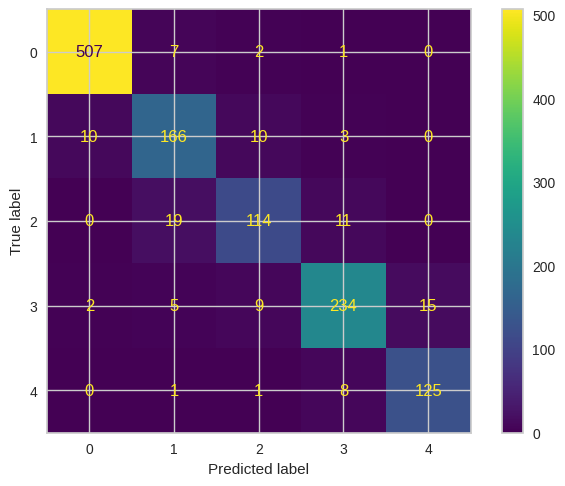

In [155]:
rf_model = RandomForestClassifier(n_estimators=100, max_features="auto", random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print(classification_report(y_test,rf_pred))
plot_confusion_matrix(rf_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, rf_pred))

## Light Gradient Boosting Machine

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       517
           1       0.84      0.89      0.87       189
           2       0.86      0.78      0.82       144
           3       0.91      0.89      0.90       265
           4       0.90      0.93      0.92       135

    accuracy                           0.92      1250
   macro avg       0.90      0.90      0.90      1250
weighted avg       0.92      0.92      0.92      1250

0.9232


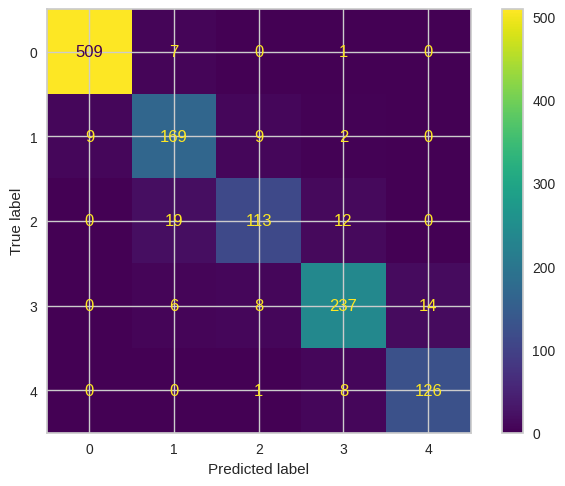

In [156]:
lgb_model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
print(classification_report(y_test,lgb_pred))
plot_confusion_matrix(lgb_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, lgb_pred))

## Gradient Boosting Classifier

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       517
           1       0.81      0.85      0.83       189
           2       0.79      0.72      0.75       144
           3       0.90      0.85      0.88       265
           4       0.87      0.92      0.89       135

    accuracy                           0.90      1250
   macro avg       0.87      0.86      0.86      1250
weighted avg       0.90      0.90      0.90      1250

0.8984


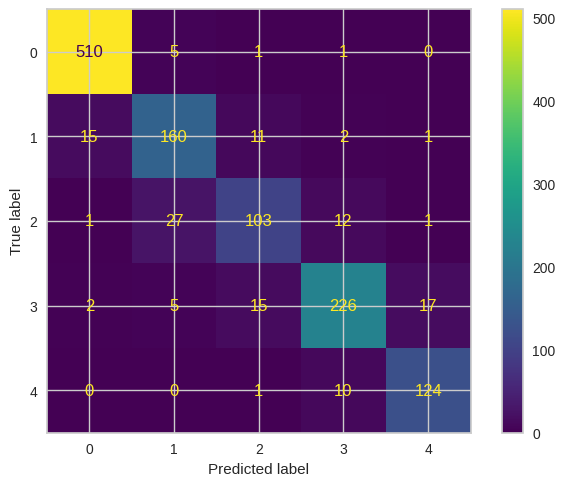

In [157]:

gb_model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
print(classification_report(y_test,gb_pred))
plot_confusion_matrix(gb_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, gb_pred))

## Decision Tree Classifier

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       517
           1       0.86      0.85      0.85       189
           2       0.82      0.81      0.81       144
           3       0.87      0.88      0.87       265
           4       0.87      0.85      0.86       135

    accuracy                           0.91      1250
   macro avg       0.88      0.87      0.88      1250
weighted avg       0.91      0.91      0.91      1250

0.908


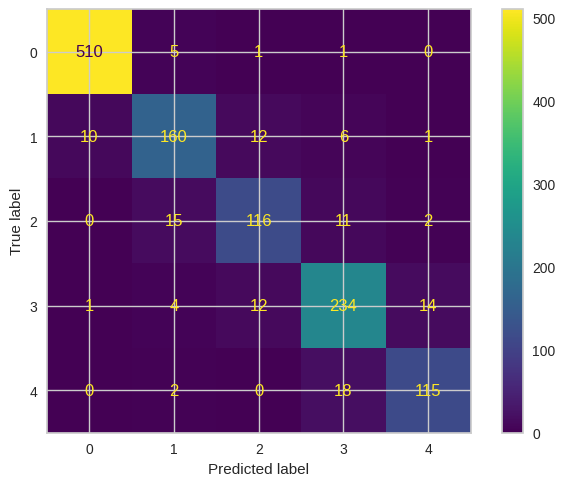

In [158]:
dt_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20, random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
print(classification_report(y_test,dt_pred))
plot_confusion_matrix(dt_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, dt_pred))

## Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       517
           1       0.80      0.84      0.82       189
           2       0.83      0.72      0.77       144
           3       0.90      0.86      0.88       265
           4       0.83      0.91      0.87       135

    accuracy                           0.90      1250
   macro avg       0.87      0.86      0.86      1250
weighted avg       0.90      0.90      0.90      1250

0.8968


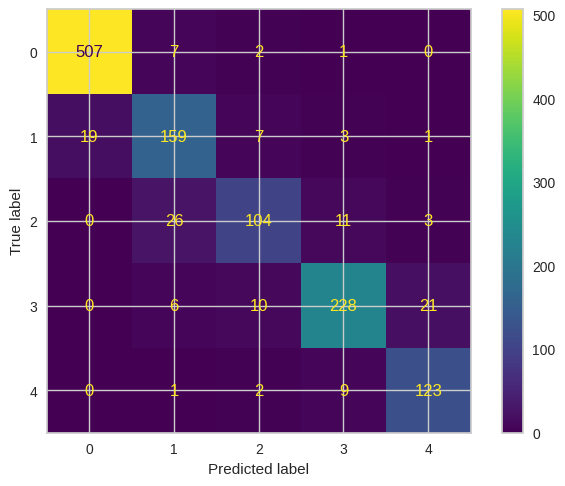

In [159]:
et_model = ExtraTreesClassifier(criterion='gini', max_depth=20, random_state=42)
et_model.fit(X_train, y_train)
et_pred = et_model.predict(X_test)
print(classification_report(y_test,et_pred))
plot_confusion_matrix(et_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, et_pred))

## K Neighbors Classifier

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       517
           1       0.74      0.72      0.73       189
           2       0.73      0.66      0.69       144
           3       0.78      0.77      0.77       265
           4       0.78      0.81      0.79       135

    accuracy                           0.83      1250
   macro avg       0.79      0.78      0.79      1250
weighted avg       0.83      0.83      0.83      1250

0.8312


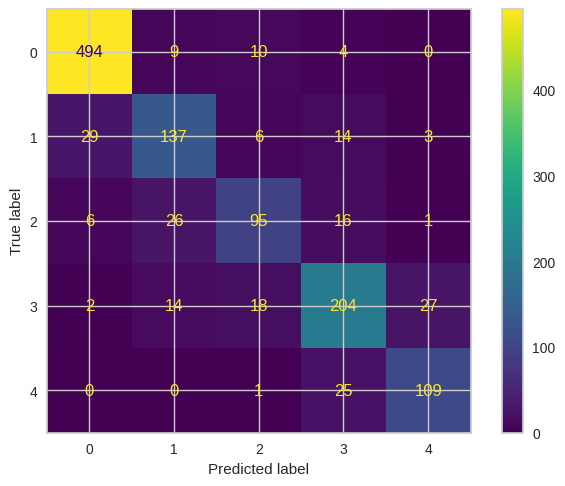

In [160]:
kn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
kn_model.fit(X_train, y_train)
kn_pred = kn_model.predict(X_test)
print(classification_report(y_test,kn_pred))
plot_confusion_matrix(kn_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, kn_pred))

## CatBoost Classifier

Learning rate set to 0.5
0:	learn: 0.8355583	total: 5.81ms	remaining: 52.3ms
1:	learn: 0.6371314	total: 10.4ms	remaining: 41.8ms
2:	learn: 0.5602731	total: 14.6ms	remaining: 34ms
3:	learn: 0.4936908	total: 18.2ms	remaining: 27.3ms
4:	learn: 0.4547274	total: 24.4ms	remaining: 24.4ms
5:	learn: 0.4281592	total: 29.5ms	remaining: 19.7ms
6:	learn: 0.3955953	total: 33.9ms	remaining: 14.5ms
7:	learn: 0.3791624	total: 39.1ms	remaining: 9.77ms
8:	learn: 0.3703671	total: 44.2ms	remaining: 4.91ms
9:	learn: 0.3417826	total: 48.4ms	remaining: 0us
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       517
           1       0.76      0.79      0.77       189
           2       0.82      0.65      0.73       144
           3       0.87      0.82      0.85       265
           4       0.83      0.92      0.87       135

    accuracy                           0.87      1250
   macro avg       0.84      0.83      0.83      1250
weighted avg       0.87   

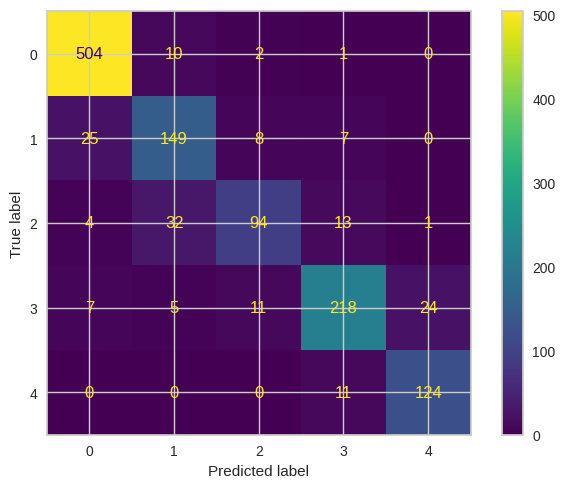

In [161]:
cat_model = CatBoostClassifier(iterations=10)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
print(classification_report(y_test,cat_pred))
plot_confusion_matrix(cat_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, cat_pred))

* Comparação

In [162]:
# função que compara os modelos, para isso, usa um dicionário {"Model Name: [predictions], ..."}
def compare_models(Y_test, predictions):
    # Create a dictionary of models and their respective accuracies
    model_accuracies = {}
    for name, prediction in predictions.items():
        # Calculate the accuracy for each model
        accuracy = sum(prediction == Y_test) / len(Y_test)
        # Add the model and its accuracy to the dictionary
        model_accuracies[name] = accuracy

    # Sort the models by their accuracy in ascending order
    sorted_models = sorted(model_accuracies, key=model_accuracies.get)

    # Print the table with the accuracy of each model
    print("Model".ljust(20), "Accuracy")
    print("-" * 30)
    for model in sorted_models:
        print(model.ljust(20), str(model_accuracies[model]).rjust(10))

In [163]:
predictions = {
    'Random Forest Classifier' : rf_pred,
    'Light Gradient Boosting Machine' : lgb_pred,
    'Gradient Boosting Classifier' : gb_pred,
    'Decision Tree Classifier' : dt_pred,
    'Extra Trees Classifier' : et_pred,
    'K Neighbors Classifier' : kn_pred,
}

compare_models(y_test, predictions)

Model                Accuracy
------------------------------
K Neighbors Classifier     0.8312
Extra Trees Classifier     0.8968
Gradient Boosting Classifier     0.8984
Decision Tree Classifier      0.908
Random Forest Classifier     0.9168
Light Gradient Boosting Machine     0.9232


Vamos, primeiramente, fazer feature engeneering.
Seguir para o notebook 2.